# Maximisation couple moyen (non-linéaire)

In [1]:
from ngsolve import *
from ngsolve.webgui import Draw
from netgen.geom2d import CSG2d, Circle, Rectangle
from copy import copy
import numpy as np
import matplotlib.pyplot as plt
from ngsolve.solvers import Newton

importing NGSolve-6.2.2105-9-g5a835126f


## 1) Définition du maillage

La première étape consiste à définir une géométrie (disque), ainsi que la finesse de maillage associée.

In [2]:
def generate_fitted_circle_mesh(N):
    geo = CSG2d()
    R=1
    x = R*2*(np.append(np.insert(np.arange(0.5,N+0.5),0,0),N)/N-0.5)
    
    circle1 = Circle( center=(0,0), radius=R, bc="left_up" ) * Rectangle( pmin=(-R,0), pmax=(0,R))
    circle2 = Circle( center=(0,0), radius=R, bc="left_bot" ) * Rectangle( pmin=(-R,-R), pmax=(0,0))
    circle3 = Circle( center=(0,0), radius=R, bc="right_bot" ) * Rectangle( pmin=(0,-R), pmax=(R,0))
    circle4 = Circle( center=(0,0), radius=R, bc="right_up" ) * Rectangle( pmin=(0,0), pmax=(R,R))
    
    materials = ["iron","air"]
    
    for i in range(len(x)-1):
        geo.Add(Rectangle( pmin=(x[i],-R), pmax=(x[i+1],R), mat = materials[i%2] ) * (circle1 + circle2 + circle3 +circle4))

    #m = geo.GenerateMesh(maxh=max([R/N,1/30])) # On doit fixer la taille du maillage sinon le volume change à cause des elts grossiers
    m = geo.GenerateMesh(maxh=1/N)
    return Mesh(m)


## 2) Définition des problèmes éléments finis

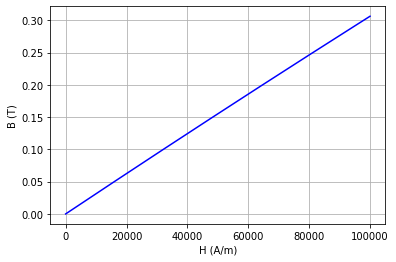

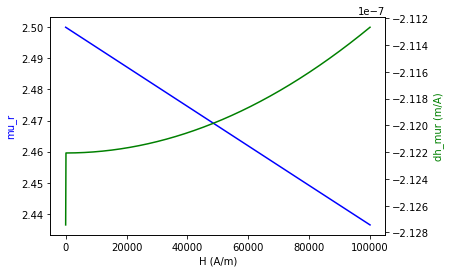

In [3]:
mu_r0 = 2
hsat = 3e6/mu_r0
mu0 = 4e-7*np.pi

def b(h):
    if str(type(h)) == "<class 'numpy.ndarray'>":
        return mu0*(2*mu_r0*h-(np.arctan(h/hsat)/np.pi+0.5)*(2*mu_r0-1)*h )
    return mu0*(2*mu_r0*h-(atan(h/hsat)/np.pi+0.5)*(2*mu_r0-1)*h )

def dbdh(h):
    if str(type(h)) == "<class 'numpy.ndarray'>":
        return -mu0*(((2*mu_r0 - 1)*(pi + 2*np.arctan(h/hsat)))/(2*np.pi) - 2*mu_r0 + (h*hsat*(mu_r0 - 1))/(np.pi*(h**2 + hsat**2)))
    return -mu0*(((2*mu_r0 - 1)*(pi + 2*atan(h/hsat)))/(2*np.pi) - 2*mu_r0 + (h*hsat*(mu_r0 - 1))/(np.pi*(h**2 + hsat**2)))

def mu(phi,rho):
    h = sqrt(grad(phi)*grad(phi)+1e-20)
    return mu0 + (b(h)/h-mu0)*rho

def dmudh(phi,rho):
    h = sqrt(grad(phi)*grad(phi)+1e-20)
    return rho*(dbdh(h)/h - b(h)/(h**2))

H = np.linspace(1e-6,1e5,1000)
mu_r = b(H)/(H*mu0)
dmu_rdh =  (dbdh(H)/H - b(H)/(H**2))/mu0

plt.plot(H,b(H), 'b-') ; plt.xlabel('H (A/m)') ; plt.ylabel('B (T)') ; plt.grid()
plt.show()

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(H,mu_r, 'b-') ; ax2.plot(H,dmu_rdh, 'g-')

ax1.set_xlabel('H (A/m)')
ax1.set_ylabel('mu_r', color='b')
ax2.set_ylabel('dh_mur (m/A)', color='g')

plt.show()

In [4]:
beta = 1;

def solvePb(rho):
    fespace_H1 = H1(mesh, order=1)
    fespace_H1.FreeDofs()[0] = False
    phi = fespace_H1.TrialFunction()
    psi = fespace_H1.TestFunction()
    
    K1 = BilinearForm(fespace_H1, symmetric=True)
    K1 +=  grad(psi)*mu(phi,rho)*grad(phi)*dx
    K2 = BilinearForm(fespace_H1, symmetric=True)
    K2 +=  grad(psi)*mu(phi,rho)*grad(phi)*dx

    K1 += psi*beta*sqrt(1-x**2)*ds(definedon=mesh.Boundaries("right_bot|left_bot"))
    K1 += -psi*beta*sqrt(1-x**2)*ds(definedon=mesh.Boundaries("left_up|right_up"))

    K2 += psi*beta*sqrt(1-y**2)*ds(definedon=mesh.Boundaries("right_up|right_bot"))
    K2 += - psi*beta*sqrt(1-y**2)*ds(definedon=mesh.Boundaries("left_up|left_bot"))
    
    phi1 = GridFunction(fespace_H1)
    phi2 = GridFunction(fespace_H1)
    Newton(K1,phi1, freedofs = fespace_H1.FreeDofs() ,printing=False, maxit=100, maxerr=2e-10,dampfactor = 0.8)
    Newton(K2,phi2, freedofs = fespace_H1.FreeDofs() ,printing=False, maxit=100, maxerr=2e-10,dampfactor = 0.8)
    
    return(phi1, phi2)

On définit ensuite les densités

In [5]:
def compliance(rho, phi):
    return Integrate(grad(phi)*mu(phi,rho)* grad(phi),mesh)/2

def objective(phi1,phi2,rho):
    return compliance(rho, phi1) - compliance(rho, phi2)


def solveAdjoint(rho,phi1,phi2):
    fespace_H1 = H1(mesh, order=1)
    fespace_H1.FreeDofs()[0] = False
    
    phi = fespace_H1.TrialFunction()
    psi = fespace_H1.TestFunction()
    
    dK1 = BilinearForm(fespace_H1, symmetric=True)
    dK1 +=  grad(psi)*mu(phi,rho)*grad(phi)*dx
    dK2 = BilinearForm(fespace_H1, symmetric=True)
    dK2 +=  grad(psi)*mu(phi,rho)*grad(phi)*dx
    
    dK1.AssembleLinearization(phi1.vec)
    dK2.AssembleLinearization(phi2.vec)
    
    dJ1 = LinearForm(fespace_H1)
    #dJ1 +=  - dmu1*InnerProduct(grad(phi1),OuterProduct(grad(phi1),grad(phi1))*grad(psi))/sqrt(1e-12+grad(phi1)*grad(phi1))*dx
    # on peut faire plus court (équivalent) : 
    
    norm_h1 = sqrt(1e-12+grad(phi1)*grad(phi1))
    dJ1 += (dmudh(phi1,rho)*norm_h1*grad(phi1)*grad(psi)/2 + mu(phi1,rho)*grad(phi1)*grad(psi))*dx 
    
    norm_h2 = sqrt(1e-12+grad(phi2)*grad(phi2))
    dJ2 = LinearForm(fespace_H1)
    dJ2 += - (dmudh(phi2,rho)*norm_h2*grad(phi2)*grad(psi)/2 + mu(phi2,rho)*grad(psi)*grad(phi2))*dx 

    dJ1.Assemble()
    dJ2.Assemble()
    
    lb1 = GridFunction(fespace_H1)
    lb2 = GridFunction(fespace_H1)
    
    lb1.vec.data = (dK1.mat.Inverse(fespace_H1.FreeDofs(), inverse="sparsecholesky").T * dJ1.vec)
    lb2.vec.data = (dK2.mat.Inverse(fespace_H1.FreeDofs(), inverse="sparsecholesky").T * dJ2.vec)
    
    
    return lb1,lb2

In [6]:
def gradient(rho,phi1,phi2,lb1,lb2):
    mu1 = mu(phi1,rho)
    mu2 = mu(phi2,rho)
    Lag = (grad(lb1)*mu1*grad(phi1) + grad(lb2)*mu2*grad(phi2))*dx # FV
    Lag += (grad(phi1)*mu1* grad(phi1) -  grad(phi2)*mu2* grad(phi2))/2*dx # fonction objectif
    rho_test = rho.space.TestFunction()
    temp = LinearForm(rho.space)
    temp += Lag.Diff(rho,rho_test)
    temp.Assemble()
    r_temp = GridFunction(rho.space)
    r_temp.vec.data = temp.vec
    return r_temp

## Optimisation

In [7]:
mesh = generate_fitted_circle_mesh(40)
fespace_rho = L2(mesh, order=0)
rho = GridFunction(fespace_rho)
rho.Set(0.5)

objFuncList = []
JparList = []
JserList = []
Jlist = []
rhoList = []
volFracList = []
descentList = []
step = 0.1
descent = GridFunction(fespace_rho)

for i in range(200):
    
    # Calculs état direct, adjoint et direction de descente
    phi1,phi2 = solvePb(rho)
    lb1,lb2 = solveAdjoint(rho,phi1,phi2)
    descent.Set(gradient(rho,phi1,phi2,lb1,lb2))
    descent.vec[:] = np.sign(descent.vec[:].FV().NumPy())
    
    rhoList.append(copy(rho))
    objFuncList.append(objective(phi1,phi2,rho))
    JparList.append(compliance(rho, phi1))
    JserList.append(compliance(rho, phi2))
    Jlist.append(JparList[-1]-JserList[-1])
    descentList.append(copy(descent))
    volFracList.append(Integrate(rho,mesh)/np.pi)
    
    print(f'{objFuncList[-1]} - step : {step}')
    
    if i>0 and objFuncList[-1]< objFuncList[-2]:
        step = min([step*1.2,1])
    elif i>0:
        step = step/2
      
    rho.Set(rhoList[i] + descentList[i]*step)
    rho.vec[:].FV().NumPy()[rho.vec[:].FV().NumPy()<0]=0
    rho.vec[:].FV().NumPy()[rho.vec[:].FV().NumPy()>1]=1
    
    if np.isnan(np.sum(rho.vec[:].FV().NumPy())):
        break
    if step < 1e-4:
        break

-18.658041516202502 - step : 0.1
-1379.6757932024775 - step : 0.1
-8624.665159764932 - step : 0.12
-30404.545762317837 - step : 0.144
-67476.37532589235 - step : 0.17279999999999998
-84199.50572178641 - step : 0.20735999999999996
-87536.40586471872 - step : 0.24883199999999994
-88798.56311031745 - step : 0.29859839999999993
-89752.65465039352 - step : 0.3583180799999999
-90305.09613323305 - step : 0.4299816959999999
-90752.37676396803 - step : 0.5159780351999999
-91129.4812580318 - step : 0.6191736422399998
-91564.99213890266 - step : 0.7430083706879997
-91983.91157073586 - step : 0.8916100448255997
-92203.25760274229 - step : 1
-92406.5599654133 - step : 1
-92580.00516962388 - step : 1
-92754.14251028583 - step : 1
-93072.86582769407 - step : 1
-93217.19698118593 - step : 1
-93453.38968317758 - step : 1
-93483.63611098111 - step : 1
-93570.40890747018 - step : 1
-93642.2101423007 - step : 1
-93727.88747035642 - step : 1
-93798.18201333086 - step : 1
-93886.2751793135 - step : 1
-93971

In [8]:
print(volFracList[-1])

0.4721145787745108


In [9]:
print(JparList[-1])

816008.3830123278


In [10]:
print(JserList[-1])

915324.4309113355


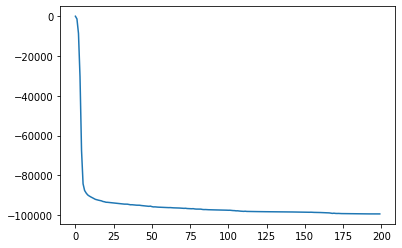

In [12]:
plt.plot(Jlist)

In [13]:
Draw(rho)

WebGuiWidget(value={'ngsolve_version': '6.2.2105-9-g5a835126f', 'mesh_dim': 2, 'order2d': 2, 'order3d': 2, 'dr…

BaseWebGuiScene

## 3) Optimisation

